<a href="https://colab.research.google.com/github/charlyBraga/analysis-price-host/blob/main/LH_DS_CharlyBraga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# O objetivo deste trabalho é explorar os dados de uma tabela de preço de aluguel para responder perguntas de negócio.

Autor: Charly Braga Ventura

Data de implementação: fevereiro de 2024

Link do repositório no Github: https://github.com/charlyBraga/analysis-price-host.git


####Instruções:

Instruções:
* Independente de qual parte do algoritmo for utilizada, execute o código logo abaixo para importar as bibliotecas.
* O módulo catboost deve ser instalado, caso não esteja.


Dicionário de dados:
*  **id**: Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo
*  **nome**: Representa o nome do anúncio
*  **host_id**: Representa o id do usuário que hospedou o anúncio
*  **host_name**: Contém o nome do usuário que hospedou o anúncio
*  **bairro_group**: Contém o nome do bairro onde o anúncio está localizado
*  **bairro**:Contém o nome da área onde o anúncio está localizado
*  **latitude**: Contém a latitude do local
*  **longitude**: Contém a longitude do local
*  **room_type**: Contém o tipo de espaço de cada anúncio
*  **price**: Contém o preço por noite em dólares listado pelo anfitrião
*  **minimo_noites**: Contém o número mínimo de noites que o usuário deve reservar
*  **numero_de_reviews**: Contém o número de comentários dados a cada listagem
*  **ultima_review**: Contém a data da última revisão dada à listagem
*  **reviews_por_mes**: Contém o número de avaliações fornecidas por mês
*  **calculado_host_listings_count**: Contém a quantidade de listagem por host
*  **disponibilidade_365**: Contém o número de dias em que o anúncio está disponível para reserva




#Questão 1. Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas. Seja criativo!


####Instalação do módulo de Machine Learning (ML) e importação de bibliotecas

In [1]:
!pip install --quiet catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt #manipular gráficos
import seaborn as sns #manipular gráficos
import numpy as np #manipular números
from catboost import CatBoostRegressor #ML
from sklearn.model_selection import train_test_split #separar dados de treino, validação e teste
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #métricas
from math import sqrt #matemática para métrica
import pickle #salvar modelo
import statsmodels.api as sm

####Carregamento da base de dados

In [3]:
df = pd.read_csv('teste_indicium_precificacao.csv')

####Impressão dos metadados na **Tabela info**. Ela informa que há 48.894 linhas (registros) no dataset, divididos em 16 colunas (variáveis). Para cada variável é exibido o tipo de dado e quantidade de registros não nulos, conforme listado abaixo. Os tipos são:
*  **int64**: número inteiro
*  **object**: texto
*  **float64**: decimal




In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

##Análise exploratória (EDA) e hipótese de negócio

###Algumas hipóteses de negócios referentes aos dados da nossa base de dados apresentados na Tabela head logo abaixo, são:

* Um dos fatores que mais influenciam no valor de aluguel é a localização. Na tabela seguinte, as variáveis "bairro", "bairro_group", "latitude", "longitude" possivelmente têm influência no preço.
* Locatários procuram locais com boas avaliações, geralmente. Na base de dados, há variáveis relacionadas à avaliação, como "numero_de_reviews", "ultima_review" e "reviews_por_mes". Um número alto de avaliações pode indicar que muitas pessoas estão utilizando o imóvel e algo está atraindo elas, seja por comentários positivos, bom preço, boa localização ou algum outro atrativo. Uma data recente de comentário é mais interessante para quem quer alugar e ter informações atualizadas do local. Comentários mais recentes são mais relevantes. Um único comentário ruim recente pode ser mais relevante que muitos comentários bons antigos, pois o local pode ter decaído em qualidade. Porém, a nível de treinamento de modelo de Machine Learning (ML), elas não nos dizem nada se o usuário aprovou ou reprovou. Seria interessante haver mais uma variável, com avaliação de 1 a 5, por exemplo.
* A pessoa locatária (representada pela variável "host_name" e "host_id") com mais de um anúncio de aluguel pode ter seu nome influenciando no preço, pois possivelmente tende a manter o padrão em todas as unidades, seja por boa qualidade ou não.
* A variável "room_type", que representa o tipo de espaço sendo alugado, naturalmente deveria ter influência no preço, pois um quarto privativo é mais caro que um compartilhado, por exemplo.
* A variável "nome", que representa a descrição do anúncio, é o chamariz inicial do anúncio. Quando bem escrito e bem representativo, deve atrair mais pessoas e, consequentemente, pode influenciar no preço.
* Espera-se que o mínimo de noites da reserva, variável "minimo_noite", influencie no preço do anúncio, pois um número baixo, por exemplo, terá um rodízio maior de pessoas, mais serviços de quarto serão necessários e haverá menos garantia de surgir locatário com frequência.
Pode ser que pessoas com muitos anúncios tenham locais de melhor qualidade e, por isso, mais caros. Mas pode acontecer também o contrário, o locatário construir muitos imóveis de baixa qualidade para aluguéis. Essa quantidade de alugueis por locatário é representada pela variável "calculado_host_listings_count".

Foi feita uma análise com variáveis separadas, porém seria interessante analisar esses dados em conjunto. Por exemplo, um aluguel de um imóvel com quarto compartilhado em uma região nobre pode ser mais caro que outro com quarto privativo em uma região periférica.

####Tabela head

In [5]:
df.head(20)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
5,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
6,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
7,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
8,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188
9,5295,Beautiful 1br on Upper West Side,7702,Lena,Manhattan,Upper West Side,40.80316,-73.96545,Entire home/apt,135,5,53,2019-06-22,0.43,1,6


###Análise da descrição dos dados



Na **Tabela de descrição** abaixo, é possível verificar:

* O menor preço é 0, o que não faz sentido para aluguel, sendo gratuito. Portanto, vou remover as linhas da tabela quando o preço tiver esse valor. O maior preço é 10.000;
* O desvio padrão do preço é muito alto comparado às outras variáveis, mais de 240, indicando que há muita discrepância entre os dados (outliers).
75% dos preços têm valores menores que 175. Isso comprova ainda mais a presença de outliers com valores muito altos, como 10.000.
* Outras métricas como média, mínimo e quantidade de registros são aplicadas a todas as variáveis.


####Tabela de descrição

In [6]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


###Análise de distribuição de dados

Os gráficos utilizados aqui servem para analisar as distribuições dos dados, ou seja, identificar onde se concentram em maior número. As variáveis foram escolhidas com base em alto desvio padrão, o que sugere a presença de muita discrepância nos dados (outliers).

####Gráfico hist

Este gráfico demonstra que a maior parte dos dados está concentrada próximo ao zero do gráfico. Percebe-se, por exemplo, que quase todos os anúncios têm preços menores que 1.000. Apesar de a disponibilidade também estar majoritariamente próxima ao ponto zero do gráfico, possui valores consideráveis ao longo do eixo horizontal do gráfico.

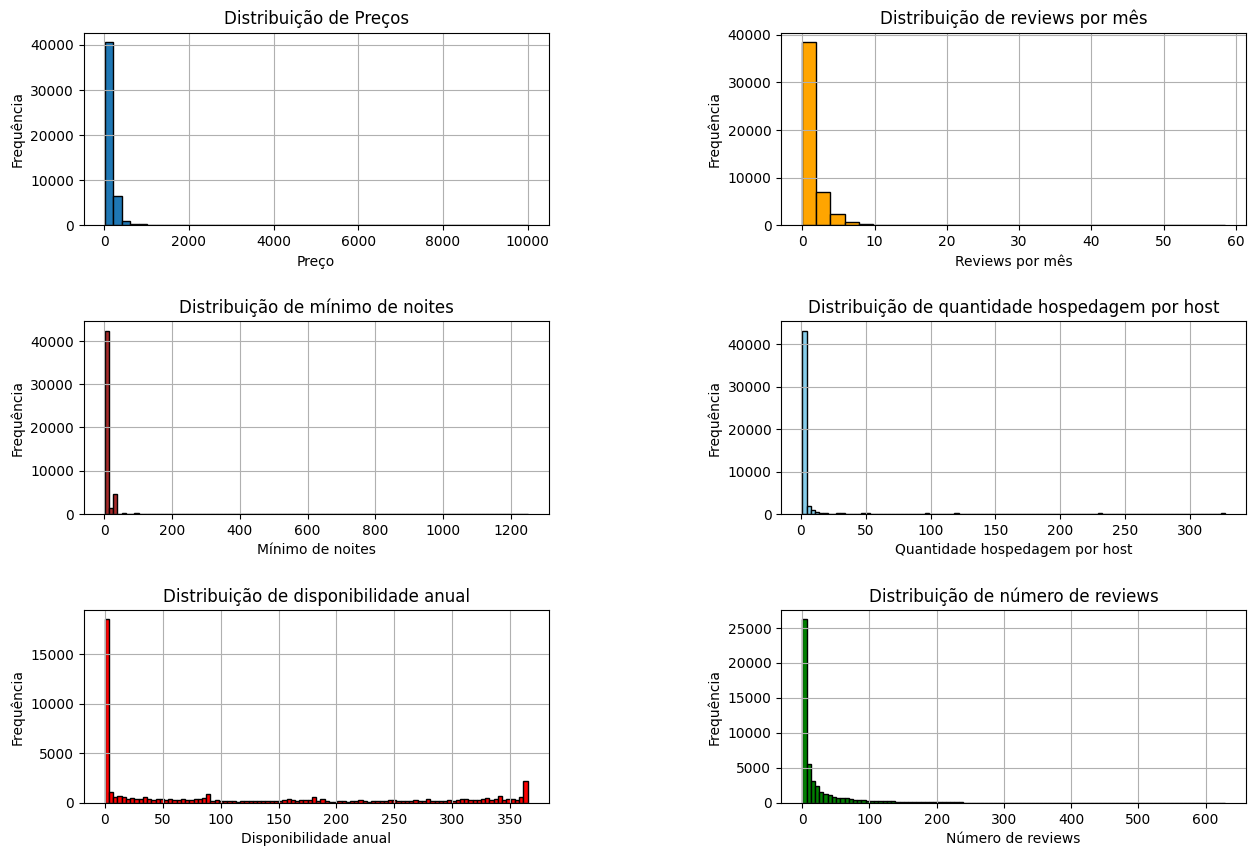

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Plot 1 - price
axs[0, 0].hist(df['price'], bins=50, edgecolor='black')
axs[0, 0].set_title('Distribuição de Preços')
axs[0, 0].set_xlabel('Preço')
axs[0, 0].set_ylabel('Frequência')
axs[0, 0].grid(True)

# Plot 2 - reviews_por_mes
axs[0, 1].hist(df['reviews_por_mes'], bins=30, edgecolor='black', color='orange')
axs[0, 1].set_title('Distribuição de reviews por mês')
axs[0, 1].set_xlabel('Reviews por mês')
axs[0, 1].set_ylabel('Frequência')
axs[0, 1].grid(True)

# Plot 3 - minimo_noites
axs[1, 0].hist(df['minimo_noites'], bins=100, edgecolor='black', color='brown')
axs[1, 0].set_title('Distribuição de mínimo de noites')
axs[1, 0].set_xlabel('Mínimo de noites')
axs[1, 0].set_ylabel('Frequência')
axs[1, 0].grid(True)

# Plot 4 - calculado_host_listings_count
axs[1, 1].hist(df['calculado_host_listings_count'], bins=100, edgecolor='black', color='skyblue')
axs[1, 1].set_title('Distribuição de quantidade hospedagem por host')
axs[1, 1].set_xlabel('Quantidade hospedagem por host')
axs[1, 1].set_ylabel('Frequência')
axs[1, 1].grid(True)

# Plot 5 - disponibilidade_365
axs[2, 0].hist(df['disponibilidade_365'], bins=100, edgecolor='black', color='red')
axs[2, 0].set_title('Distribuição de disponibilidade anual')
axs[2, 0].set_xlabel('Disponibilidade anual')
axs[2, 0].set_ylabel('Frequência')
axs[2, 0].grid(True)

# Plot 6 - numero_de_reviews
axs[2, 1].hist(df['numero_de_reviews'], bins=100, edgecolor='black', color='green')
axs[2, 1].set_title('Distribuição de número de reviews')
axs[2, 1].set_xlabel('Número de reviews')
axs[2, 1].set_ylabel('Frequência')
axs[2, 1].grid(True)

plt.show()

####Gráfico boxplot

O boxplot se divide os dados em quartis e demonstra a distribuição entre eles. A área onde está o retângulo azul indica onde a maior quantidade de dados se encontra. Os poucos círculos à direita dos gráficos indicam a presença de outliers. Os gráficos que apresentaram maior discrepância foram os de preço, reviews por mês, mínimo de noites e quantidade de hospedagem por host.

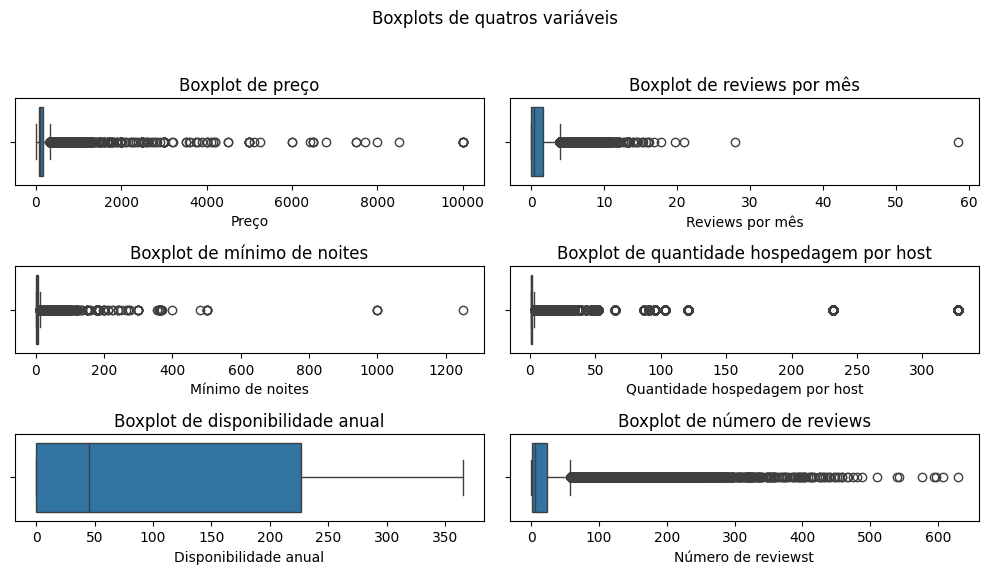

In [42]:
# Boxplot para todo o conjunto de dados
fig, axs = plt.subplots(3, 2, figsize=(10, 6))
fig.suptitle('Boxplots de quatros variáveis')

sns.boxplot(x=df['price'], ax=axs[0, 0])
axs[0, 0].set_title('Boxplot de preço')
axs[0, 0].set_xlabel('Preço')

sns.boxplot(x=df['reviews_por_mes'], ax=axs[0, 1])
axs[0, 1].set_title('Boxplot de reviews por mês')
axs[0, 1].set_xlabel('Reviews por mês')

sns.boxplot(x=df['minimo_noites'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot de mínimo de noites')
axs[1, 0].set_xlabel('Mínimo de noites')

sns.boxplot(x=df['calculado_host_listings_count'], ax=axs[1, 1])
axs[1, 1].set_title('Boxplot de quantidade hospedagem por host')
axs[1, 1].set_xlabel('Quantidade hospedagem por host')

sns.boxplot(x=df['disponibilidade_365'], ax=axs[2, 0])
axs[2, 0].set_title('Boxplot de disponibilidade anual')
axs[2, 0].set_xlabel('Disponibilidade anual')

sns.boxplot(x=df['numero_de_reviews'], ax=axs[2, 1])
axs[2, 1].set_title('Boxplot de número de reviews')
axs[2, 1].set_xlabel('Número de reviewst')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

###Análise de correlações de dados separadamente

A **Tabela de correlação** abaixo mostra como os dados se relacionam entre si. Quando se correlacionam, os valores se aproximam de 1 ou de -1, indicando neste último caso uma correlação inversa. Valores próximos de 0 indicam pouca correlação. Algumas observações podem ser feitas a partir do gráfico:

* Individualmente, o preço tem poucas correlações com outros dados. A maior correlação é com a longitude, de -0,15, indicando que quando a longitude diminui, o preço tende a aumentar.
* Como era esperado, o número de reviews e reviews por mês são as variáveis com a maior correlação individual, 0,6.

In [43]:
df.corr()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
id,1.000000,0.588239,-0.003159,0.091049,0.010585,-0.012053,-0.320081,0.180100,0.133230,0.085690
host_id,0.588239,1.000000,0.020142,0.127159,0.015312,-0.017060,-0.140354,0.209605,0.154954,0.203727
latitude,-0.003159,0.020142,1.000000,0.084849,0.033905,0.025909,-0.015176,-0.018681,0.019547,-0.010675
longitude,0.091049,0.127159,0.084849,1.000000,-0.149889,-0.062922,0.059069,0.138674,-0.114748,0.082712
price,0.010585,0.015312,0.033905,-0.149889,1.000000,0.042810,-0.047920,-0.050553,0.057450,0.081839
minimo_noites,-0.012053,-0.017060,0.025909,-0.062922,0.042810,1.000000,-0.081575,-0.127346,0.131315,0.145942
numero_de_reviews,-0.320081,-0.140354,-0.015176,0.059069,-0.047920,-0.081575,1.000000,0.589124,-0.072417,0.171822
reviews_por_mes,0.180100,0.209605,-0.018681,0.138674,-0.050553,-0.127346,0.589124,1.000000,-0.047376,0.163712
calculado_host_listings_count,0.133230,0.154954,0.019547,-0.114748,0.057450,0.131315,-0.072417,-0.047376,1.000000,0.225805
disponibilidade_365,0.085690,0.203727,-0.010675,0.082712,0.081839,0.145942,0.171822,0.163712,0.225805,1.000000


##Limpeza de dados

### Remoção de registros com preço igual a zero

Esta remoção é justificada pelo fato de que não faz sentido existir aluguel gratuito, o que indica a possibilidade de ter sido um erro de preenchimento.

In [7]:
qtd_price_zero = len(df[df['price']==0])
print(f'Quantidade de preços com valores iguais a zero: {qtd_price_zero}')
df.drop(index=df[df['price']==0].index, inplace=True)
print(f'Quantidade de registros após remoção de preços com valores iguais a zero: {len(df)}')

Quantidade de preços com valores iguais a zero: 11
Quantidade de registros após remoção de preços com valores iguais a zero: 48883


#### Busca por valores nulos:

* Foram encontrados 16 registros referentes à variável "nome" e 21 registros referentes a "host_name" nulos. Irei remover estes valores para não interferir no modelo.
* Há 10.051 imóveis sem review.

Impressão da quantidade de valores nulos para cada variável

In [8]:
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10051
reviews_por_mes                  10051
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

####Para confirmar que o número de "numero_de_reviews" igual a zero corresponde à mesma quantidade de valores nulos em "ultima_review" e "reviews_por_mes", assegurando que isso não representa um erro de preenchimento.

O resultado abaixo demonstra que há 10.051 números de reviews iguais a zero, a mesma quantidade que as outras variáveis referentes a reviews com valores nulos. Isso sugere que não há necessidade de remoção. Podemos inserir o valor zero quando "reviews por mês" for nulo e uma data em "ultima_review" na mesma situação. Essa data pode ser algo como 1970-01-01, que está longe de qualquer data presente na base de dados e, por isso, não influenciará negativamente na predição. Ainda como bônus, manteremos 10.051 registros importantes, pois a falta de review pode ter relação com o preço.

In [9]:
print('Número de reviews igual a zero: ' +  str(len(df[df['numero_de_reviews'] == 0])))

Número de reviews igual a zero: 10051


Transformação de "ultima_review" e na "review_por_mes"

In [9]:
df['ultima_review'].fillna('1970-01-01', inplace=True)
df['reviews_por_mes'].fillna(0, inplace=True)

####Remoção de valores nulos e impressão da lista com valores nulos para comprovar que foram removidos

In [10]:
df.dropna(subset=['nome'], inplace=True)
df.dropna(subset=['host_name'], inplace=True)
df.isnull().sum()

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

Registros restantes na base de dados

In [12]:
print(f'Quantidade de registros restantes após remoção de valores nulos: {len(df)}')

Quantidade de registros restantes após remoção de valores nulos: 48846




---


#Questão 2a. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Primeiramente, a pessoa precisaria informar quais são os objetivos dela: se está preocupada com o preço, se deseja um lugar próximo do trabalho, se prefere morar em um lugar afastado de centros urbanos, se busca um bairro seguro e atrativo, dentre outras informações. Apesar de ser uma escolha bastante pessoal, alguns pontos que podem auxiliar essa pessoa na escolha do local são:

* **Preço**: Um maior preço pode indicar maior receita e, consequentemente, maior investimento no imóvel e melhor localização, como bairros mais seguros, por exemplo.
* **Quantidade de reviews**: Muitas reviews podem indicar alta demanda e um bom local para estadia.
* **Disponibilidade**: A disponibilidade limitada pode indicar alta demanda, mas também é importante considerar a relação entre oferta e demanda.
Localização e acessibilidade: Bairros bem localizados e acessíveis são geralmente mais atraentes para os hóspedes.

#Questão 2b. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

####Uma correlação alta entre variáveis tende a se aproximar do valor 1 para relações diretas ou -1 para relações inversas. Valores próximos de 0 indicam baixa correlação. Abaixo, foi construído um código para verificar as correlações independentes das variáveis "minimo_noites" e "disponibilidade_365" com "price". No entanto, conforme demonstrado abaixo, as correlações destas variáveis com o preço foram muito próximas de zero, indicando baixa correlação quando analisadas individualmente.

In [15]:
corr_minimo = round(df['minimo_noites'].corr(df['price']), 4)
print(f'Correlação de mínimo de noites com preço: {corr_minimo}')
corr_disponibilidade = round(df['disponibilidade_365'].corr(df['price']), 4)
print(f'Correlação de disponibilidade ao longo do ano com preço: {corr_disponibilidade}')

Correlação de mínimo de noites com preço: 0.0428
Correlação de disponibilidade ao longo do ano com preço: 0.0818


####Agora, fazendo uma análise conjunta das variáveis "minimo_noites" e "disponibilidade_365" em relação ao "price", conforme os resultados obtidos pelo código de mínimos quadrados ordinários abaixo, e focando apenas na correlação apesar de termos acesso a mais dados, observei uma correlação considerável, embora não muito forte. Em relação ao preço, "minimo_noites" apresentou uma correlação de 0,3780 e "disponibilidade_365" uma correlação de 0,141. Assim, essas variáveis independentes influenciam o preço de maneira direta quando existem em conjunto.

In [17]:
a = df[['minimo_noites', 'disponibilidade_365']]
b= df['price']
A = sm.add_constant(a)
modelo = sm.OLS(b, A).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     188.8
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           2.12e-82
Time:                        00:06:49   Log-Likelihood:            -3.3688e+05
No. Observations:               48846   AIC:                         6.738e+05
Df Residuals:                   48843   BIC:                         6.738e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 134.2179    

#Questão 2c. Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Fazendo uma análise da **Tabela tail**, anúncios de mais alto valor frequentemente destacam o tipo ou o tamanho do imóvel (como "*apartment*", "*studio*", "*loft*", "*spacious*"), características de luxo ("*luxury*"), número de quartos ("*1BR*", "*bedroom*"), e a localização ("*East*", "*Manhattan*", "*West*", "*Williamsburg*", "*Brooklyn*", "*Midtown*", "*Central*", "*Village*"). Essas palavras chaves se repentes constantemente para valores altos de hospedagem. Vou onsiderar aqui valores quando igual ou maior que 175, pelo fato da nossa análise anterior esses valores representam apenas 25% dos dados, os outros 75% estão abaixo disso.

####Tabela tail: impressão de alguns lugares caros, com valor acima de 175,  para ser possível verificar padrões do nome.

In [19]:
df[(df['price']>175) & (df['price']<200)].tail(10)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
48680,36382148,Lower East Side 1-Bedroom,273568164,Doug,Manhattan,Lower East Side,40.71958,-73.98741,Entire home/apt,198,30,0,1970-01-01,0.0,1,152
48683,36382847,Comfort home,266211707,Yan,Brooklyn,Sunset Park,40.64439,-74.01816,Private room,185,1,0,1970-01-01,0.0,2,177
48691,36386298,Spacious 3 Bedroom Duplex w/ Huge Backyard,273596828,Enoma,Brooklyn,Bedford-Stuyvesant,40.67959,-73.94987,Entire home/apt,180,3,0,1970-01-01,0.0,1,133
48697,36388748,Private Times Square Room with Pool/Gym,217557021,Jas,Manhattan,Hell's Kitchen,40.76170,-73.99815,Private room,180,3,0,1970-01-01,0.0,1,365
48727,36407969,"1 BDRM SPACIOUS ,QUIET, EAST VILLAGE ARTIST O...",273741577,Lynn,Manhattan,East Village,40.72388,-73.98354,Entire home/apt,178,1,0,1970-01-01,0.0,1,35
48744,36415915,Two bedroom cute apartment in the lower east side,246222122,Anna,Manhattan,East Village,40.72874,-73.98344,Entire home/apt,198,2,0,1970-01-01,0.0,2,344
48816,36447683,2B2B/3 beds entire place in luxury building,24680832,Angela,Queens,Long Island City,40.74754,-73.94194,Entire home/apt,180,3,0,1970-01-01,0.0,1,13
48829,36450318,"LUXURY, PRIVATE APT ACROSS FROM EMPIRE STATE",151831356,Michael,Manhattan,Midtown,40.74607,-73.98599,Entire home/apt,199,1,0,1970-01-01,0.0,1,14
48847,36455402,Cute plant friendly studio in hip Brooklyn area!,184501278,Em,Brooklyn,Crown Heights,40.67198,-73.95329,Entire home/apt,180,1,0,1970-01-01,0.0,1,165
48883,36482783,Brooklyn Oasis in the heart of Williamsburg,274307600,Jonathan,Brooklyn,Williamsburg,40.71790,-73.96238,Private room,190,7,0,1970-01-01,0.0,1,341




---


#3.Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


Estamos resolvendo um problema de regressão, pois a variável dependente "price" é contínua e não categórica.

É possível utilizar a Decision Tree, que é adequada tanto para regressão linear quanto não linear. No entanto, para dados muito complexos, pode ocorrer overfitting devido ao número de níveis que a árvore binária cria. Para enfrentar essa complexidade, podemos utilizar RandomForest, que cria várias árvores de decisão de forma aleatória. Se todos os dados fossem lineares, a regressão linear seria uma opção viável, mas, dado que muitos dados não são lineares e incluem variáveis categóricas, optamos por considerar as árvores.

Um desafio com DecisionTree e RandomForest é que eles requerem dados numéricos, demandando um extenso pré-processamento para converter variáveis categóricas em numéricas. Para superar isso e trabalhar com todos os tipos de dados sem necessidade de conversões prévias, optei por utilizar o CatBoostRegressor neste projeto. Esta técnica, baseada em Decision Tree, consegue lidar com dados categóricos e é eficaz com dados complexos e em grandes volumes.

As métricas de desempenho utilizadas aqui são:

* **RMSE (Root Mean Squared Error)**: útil quando grandes erros são  indesejáveis.
* **MAE (Mean Absolute Error)**: fornece uma ideia do erro médio.
* **R-quadrado (coeficiente de determinação)**: indica a proporção da variância dos preços que pode ser prevista a partir das características.

O objetivo aqui é verificar se algumas varíaveis podem ter somente valores únicos. Se tiver elas não serão utilizadas na entrada do modelo, por não definir um padrão que contribua com a predição. Como era esperado,  unica encontrada foi id.

In [ ]:
print(f'Quantidade de valores repetidos nas variáveis seguintes (total de registros: {df.shape[0]}).')
def print_qtdd_duplicatas(df_duplicate, var):
    duplicate =  df_duplicate[var].duplicated()
    print(f'{var}: {duplicate.sum()}')

print_qtdd_duplicatas(df, 'id')
print_qtdd_duplicatas(df, 'nome')
print_qtdd_duplicatas(df, 'host_id')
print_qtdd_duplicatas(df, 'host_name')

Quantidade de valores repetidos nas variáveis seguintes (total de registros: 48274).
id: 0
nome: 956
host_id: 10863
host_name: 36830
latitude: 29253
longitude: 33655


####Remoção de outliers para melhorar a predição. O valor limite foi definido com base em estatísticas e em testes empíricos realizados para obter o maior coeficiente de determinação (R-quadrado) possível. Este processo encontrou um bom equilíbrio entre manter a maior parte dos dados e aumentar o valor de R-quadrado



In [ ]:
del_price = df.loc[df['price'] > 1000].index
df = df.drop(del_price)
del_minimo = df.loc[df['minimo_noites'] > 400].index
df = df.drop(del_minimo)
del_reviews_mes = df.loc[df['reviews_por_mes'] > 20].index
df = df.drop(del_reviews_mes)
del_host_list = df.loc[df['calculado_host_listings_count'] > 150].index
df = df.drop(del_host_list)

In [ ]:
percent_del_price = str(round(len(del_price)/len(df)*100,2)).replace('.',',')
print(f'A quantidade de registros removidos pelo preço alto (outliers) foi de {len(del_price)}, representando {percent_del_price }\% dos registros totais.')
print(f'Total de resgistros restantes: {len(df)}.')

A quantidade de registros removidos pelo preço alto (outliers) foi de 153, representando 0,32\% dos registros totais.
Total de resgistros restantes: 48035.


####Execução do código de ML com a técnica CatBoostRegressor para predição de preço

Execução da ML. Algumas informações importantes:

* Os hiperparâmetros foram definidos com base em resultados empíricos. Por exemplo, a taxa de aprendizado foi estabelecida com base nas melhores métricas e conforme o comportamento do gráfico de erro. A quantidade de iterações foi incrementada à medida que o coeficiente de determinação (R-quadrado) aumentava, porém de forma a evitar overfitting.
* As entradas foram selecionadas com base na correlação observada anteriormente (se houver pelo menos uma correlação mínima, a variável foi utilizada) e de acordo com os dados de entrada mencionados na questão 4. A variável "nome" foi excluída, pois é equivalente ao "host_id" e não traria nenhum ganho adicional, apenas um aumento no processamento. A técnica CatBoostRegressor é capaz de converter variáveis categóricas em numéricas para serem utilizadas em sua decision tree.
* A variável "nome" contém algumas palavras-chave que estão relacionadas com preços mais altos. Seria possível criar um sistema de NLP para extrair estas palavras-chave e utilizá-las posteriormente no CatBoostRegressor. No entanto, devido ao grande aumento na dificuldade e à necessidade de mais tempo para implementação, análise e testes, o NLP não foi implementado. Assim, todas as variáveis categóricas de entrada são tratadas como valores numéricos pela técnica de ML.





0:	learn: 116.6891675	test: 114.6969915	best: 114.6969915 (0)	total: 179ms	remaining: 59m 49s
500:	learn: 101.8411458	test: 100.1786382	best: 100.1786382 (500)	total: 1m 3s	remaining: 40m 59s
1000:	learn: 94.5481710	test: 93.2863156	best: 93.2863156 (1000)	total: 2m 18s	remaining: 43m 40s
1500:	learn: 90.7168172	test: 89.9303173	best: 89.9303173 (1500)	total: 3m 33s	remaining: 43m 48s
2000:	learn: 88.4685929	test: 88.1623757	best: 88.1623757 (2000)	total: 5m 5s	remaining: 45m 47s
2500:	learn: 86.9952142	test: 87.1468969	best: 87.1468969 (2500)	total: 6m 47s	remaining: 47m 28s
3000:	learn: 85.9166450	test: 86.5038573	best: 86.5038573 (3000)	total: 8m 25s	remaining: 47m 46s
3500:	learn: 85.0777205	test: 86.0599399	best: 86.0599399 (3500)	total: 9m 40s	remaining: 45m 35s
4000:	learn: 84.4470413	test: 85.7524485	best: 85.7524485 (4000)	total: 11m 20s	remaining: 45m 20s
4500:	learn: 83.9330988	test: 85.5213851	best: 85.5213851 (4500)	total: 12m 33s	remaining: 43m 13s
5000:	learn: 83.4911833

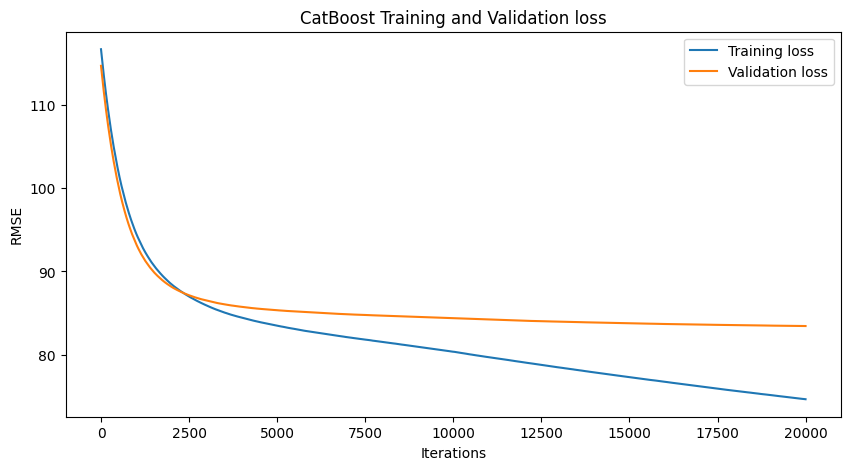

In [ ]:
# Salvando o modelo no diretório atual
def save_model(model):
  with open('model_price_catboost.pkl', 'wb') as arquivo:
      pickle.dump(model, arquivo)

#Função para imprimir métricas
def print_performance(y_test, y_pred):
  # Calculando as métricas
  rmse = sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  # Imprime métricas
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R^2: {r2}")

# Função para plotar o histórico de perda
def plot_loss(model):
  evals_result = model.get_evals_result()
  plt.figure(figsize=(10, 5))
  plt.plot(evals_result['learn']['RMSE'], label='Training loss')
  plt.plot(evals_result['validation']['RMSE'], label='Validation loss')
  plt.title('CatBoost Training and Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('RMSE')
  plt.legend()
  plt.show()

#Função para define hyperparâmetros do modelo
def define_model():
  # Lista de nomes das colunas categóricas
  cat_features = ['nome', 'bairro_group', 'bairro','room_type']
  # Inicializando o modelo CatBoostRegressor
  model = CatBoostRegressor(
      iterations=20000,
      learning_rate=0.001,
      depth=10,
      eval_metric='RMSE',
      random_seed=1,
      verbose=500,
      use_best_model=True,
      cat_features = cat_features #define dados categóricos que serão convertidos em numéricos
      #text_features = cat_features
  )
  return model

#Função para preparar os dados para a ML
def prepare_dataset():
  #Convert data em formato de string para formato data
  df['ultima_review'] = pd.to_datetime(df['ultima_review'])
  #Define dados variáveis de entrada
  dataset = [
  'nome','host_id',
  'bairro_group', 'bairro', 'latitude',
  'longitude','room_type', 'minimo_noites',
  'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
  'calculado_host_listings_count', 'disponibilidade_365'
  ]
  #Define as vaiáveis de entrada (X) e varíavel de resultado de saída (y)
  X = df[dataset]
  y = df['price']
  # Separa os dados em 80% para treino e 20% para teste
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
  # Segunda divisão: separar o conjunto de treino e validação
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1875, random_state=1)  # 0.25 x 0.8 = 0.2
  return X_train, y_train, X_val, y_val, X_test, y_test

#Obtem dados separados
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset()
#Obtem modelo
model = define_model()
#Treinamento
model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50
)
#Realiza teste de predição
y_pred = model.predict(X_test)
#Salva modelo
save_model(model)
#Imprime e plota resultados
print_performance(y_test, y_pred)
plot_loss(model)



---


#Questão 4. Supondo um apartamento com as seguintes características abaixo, *Qual seria a sua sugestão de preço?
```
{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

```



####O código abaixo responde à Questão 4. Inicialmente, carrega o modelo salvo e o executa com base nos dados de entrada "X" para determinar o preço com base nas características desses dados.

In [ ]:
# Cararregar o modelo
def load_model():
  with open('model_price_catboost.pkl', 'rb') as arquivo:
      model = pickle.load(arquivo)


# Dados de entrada
X = {
  'nome': ['Skylit Midtown Castle'],
  'host_id': [2845],
  #'host_name': ['Jennifer'],
  'bairro_group': ['Manhattan'],
  'bairro': ['Midtown'],
  'latitude': [40.75362],
  'longitude': [-73.98377],
  'room_type': ['Entire home/apt'],
  'minimo_noites': [1],
  'numero_de_reviews': [45],
  'ultima_review': [pd.to_datetime('2019-05-21')],
  'reviews_por_mes': [0.38],
  'calculado_host_listings_count': [2],
  'disponibilidade_365': [355]
}

# Converte para DataFrame
X_df = pd.DataFrame.from_dict(X)
pred_price = model.predict(X_df)

Preço predito: 280.75


####Preço encontrado com base nos dados de entrada

In [ ]:
pred_price_format = round(pred_price[0],2)
print(f"Preço predito: {pred_price_format }")

Preço predito: 280.75
